### 선형회귀기반 분류 알고리즘 학습 - LogisticRegression + 교차검증

- 이진분류 및 다중분류 가능
- 분류지만 선형회귀식기반의 알고리즘이라서 Regresion

[1] 모듈로딩 및 데이터 준비 <hr>

In [2]:
## [1-1] 모듈로딩 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 

#### [1] 데이터 준비 및 확인

In [3]:
## [1-2] 데이터 준비 
filename='../data/iris.csv'

In [4]:
## 데이터 로딩
irisDF= pd.read_csv(filename)
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


[2] 데이터 확인<hr>

- 2개 품종만 추출 ==> 'Setosa', 'Versicolor'

In [5]:
## 품종 컬럼의 고유값 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [6]:
## boolean Index 사용해서 2개 품종 데이터 추출 
dataDF=irisDF[irisDF.variety != 'Virginica'].copy()
dataDF.shape 

(100, 5)

- 2개 품종 식별 가능한 피쳐 선택

In [7]:
dataDF[dataDF['variety'] == 'Setosa']['petal.length']

0     1.4
1     1.4
2     1.3
3     1.5
4     1.4
5     1.7
6     1.4
7     1.5
8     1.4
9     1.5
10    1.5
11    1.6
12    1.4
13    1.1
14    1.2
15    1.5
16    1.3
17    1.4
18    1.7
19    1.5
20    1.7
21    1.5
22    1.0
23    1.7
24    1.9
25    1.6
26    1.6
27    1.5
28    1.4
29    1.6
30    1.6
31    1.5
32    1.5
33    1.4
34    1.5
35    1.2
36    1.3
37    1.4
38    1.3
39    1.5
40    1.3
41    1.3
42    1.3
43    1.6
44    1.9
45    1.4
46    1.6
47    1.4
48    1.5
49    1.4
Name: petal.length, dtype: float64

In [8]:
SETO = dataDF['variety'] == 'Setosa'
VESI = dataDF['variety'] == 'Versicolor'

In [9]:
dataDF[SETO]['petal.length']

0     1.4
1     1.4
2     1.3
3     1.5
4     1.4
5     1.7
6     1.4
7     1.5
8     1.4
9     1.5
10    1.5
11    1.6
12    1.4
13    1.1
14    1.2
15    1.5
16    1.3
17    1.4
18    1.7
19    1.5
20    1.7
21    1.5
22    1.0
23    1.7
24    1.9
25    1.6
26    1.6
27    1.5
28    1.4
29    1.6
30    1.6
31    1.5
32    1.5
33    1.4
34    1.5
35    1.2
36    1.3
37    1.4
38    1.3
39    1.5
40    1.3
41    1.3
42    1.3
43    1.6
44    1.9
45    1.4
46    1.6
47    1.4
48    1.5
49    1.4
Name: petal.length, dtype: float64

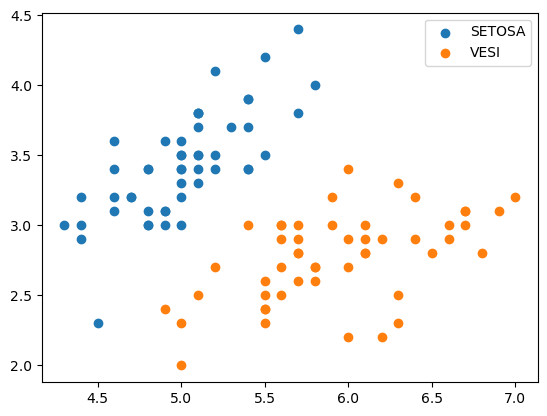

In [10]:
plt.scatter(dataDF[SETO]['sepal.length'], dataDF[SETO]['sepal.width'], label='SETOSA')
plt.scatter(dataDF[VESI]['sepal.length'], dataDF[VESI]['sepal.width'], label='VESI')

plt.legend()
plt.show()

- 꽃잎의 길이와 너비(petal.length, petal.width) 특성만 추출

In [11]:
dataDF.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

In [12]:
dataDF=dataDF[dataDF.columns[2:]].copy()

In [13]:
dataDF.shape

(100, 3)

In [14]:
dataDF.head(3)

,petal.length,petal.width,variety
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa


In [15]:
## - 품종컬럼 문자열 ==> 수치형태 변환한 컬럼 추가 
pd.set_option('future.no_silent_downcasting', True)
labelToNum={'Setosa' : 0, 'Versicolor':1}
dataDF['variety_no']=dataDF.variety.replace(labelToNum )

In [16]:
dataDF.head(3)

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0


In [17]:
dataDF.corr(numeric_only=True)

,petal.length,petal.width
petal.length,1.000000,0.979322
petal.width,0.979322,1.000000


#### [2] 데이터 가공

- 피쳐/특성/독립과 타겟/클래스/종속변수 분리

In [18]:
featureDF = dataDF[dataDF.columns[:2]]
classDF = dataDF.variety_no

In [19]:
# object 타입 ==> int 타입으로 변환
classDF=classDF.astype('int')
classDF

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: variety_no, Length: 100, dtype: int64

In [20]:
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (100, 2)  classDF : (100,)


- 훈련용/테스트용 분리

In [21]:
## - 분류시에는 훈련용/테스트용에 동일한 비율로 타겟이 배분 
## - stratify 매개변수 : 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리 
train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)

In [22]:
print(f'[TRAIN] train_X : {train_X.shape}   train_y : {train_y.shape}')
print(f'[TEST] test_X : {test_X.shape} test_y : {test_y.shape}')

[TRAIN] train_X : (80, 2)   train_y : (80,)
[TEST] test_X : (20, 2) test_y : (20,)


In [23]:
## 데이터셋별로 클래스 개수 확인 
test_y.value_counts(), train_y.value_counts()

(variety_no
 1    10
 0    10
 Name: count, dtype: int64,
 variety_no
 1    40
 0    40
 Name: count, dtype: int64)

- 특성/피쳐 2개에 대한 스케일링 진행 ==> 피쳐의 값의 범위 일치 

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [25]:
## StandardScaler : 평균 0, 표준편차 1 즉, 정규 분포 따르도록 스케일링 
## 훈련용 DataSet 기반의 스케일러는 테스트용 DS, 사용자 데이터에 대해 스케일링 진행함 
scaler = StandardScaler()

scaler.fit(train_X)

StandardScaler()

In [26]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 
print(scaler.var_, scaler.mean_)

[2.12549375 0.32415   ] [2.8725 0.79  ]


In [27]:
# 훈련데이터와 테스트 데이터 스케일링 진행
# ==> 훈련용 생성한 스케일러로 훈련용, 테스트용 변환 진행 
# ==> 향후 임의의 새로운 데이터 예측(predict)시에도 해당 스케일러 적용
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀

In [28]:
# 학습모델 객체
logR=LogisticRegression()

In [29]:
# 학습 진행 ==> 훈련용 데이터 진행 fit(2D, 1D)
logR.fit(train_scaled_X, train_y)

LogisticRegression()

In [30]:
# 학습 진행 후 설정되는 매개변수/파라미터 ===> 모델 파라미터 
# 파라메타명_
logR.classes_

array([0, 1])

In [31]:
# 피쳐 개수만큼 존재함. 피쳐*coef_
logR.coef_

array([[2.03218022, 1.8833978 ]])

In [32]:
# 바이어스/절편
logR.intercept_

array([0.25012681])

#### [4] 성능평가
- 이유 : 모델이 제대로 잘 만들어 졌는지 확인
- 과대적합/과소적합 체크
    * 과대적합/과적합/오버피팅(Overfitting) : 훈련 점수 > 테스트 점수
    * 과소적합/언더피팅(Underfitting) : 훈련과 테스트 점수 모두 낮음
    * 최적적합 : 훈련 점수와 테스트 점수 비슷 높은 점수 

- 점수 : 정확도(accuary_score)

In [33]:
train_score=logR.score(train_scaled_X, train_y)
test_score= logR.score(test_scaled_X, test_y)

In [34]:
print(f'train_score : {train_score}, test_score  : {test_score}')

train_score : 1.0, test_score  : 1.0


- 분류용 성능지표 ==>  sklearn.metrics 모듈
<pre>
    * 정밀도(precision) : 모델(예측값) 기준에서 양성/Positive를 제대로 예측한 비율
    * 재현율(Recall)    : 정답 기준에서 양성/Positive를 제대로 예측한 비율
    * F1-score          : 정밀도와 재현율의 조합한 계산법 <== 일반적인 경우 대부분 분류 성능 지표로 사용
    * 정확도(Accuracy)  : 정답을 맞춘 비율 <= 불균형 데이터셋에 신뢰성 떨어짐
    * 오차행렬(confusion_matrix) : 2진 분류에서 정답과 예측에 대한 평가표 
 </pre>   

In [35]:
## 분류 관련 성능지표 로딩
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
# 테스트 데이터기반으로 예측값 추출
y_pred=logR.predict(test_scaled_X)

y_pred

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0])

- [정밀도 점수] 

In [37]:
precision_score(test_y, y_pred)

1.0

In [38]:
recall_score(test_y, y_pred)

1.0

In [39]:
f1_score(test_y, y_pred)

1.0

In [40]:
print( classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [41]:
confusion_matrix(test_y, y_pred)

array([[10,  0],
       [ 0, 10]])

- 오차확인 : 손실/비용함수 => 알고리즘 마다 다름 log_loss()
    * 알고리즘마다 손실/비용함수가 다름 ! 

In [42]:
from sklearn.metrics import log_loss

In [43]:
## predict() : 확률을 보고 결정된 클래스/타겟 반환
y_pred=logR.predict(test_scaled_X)
print(y_pred)

## predict_proba():  확률값을 반환
y_pred_proba=logR.predict_proba(test_scaled_X)
print(y_pred_proba)

## 손실 : 정답 - 예측값 
##        정답 1일 때의 손실    정답 0일 때의 손실 
probaValue = [[],[]]
for pred, proba in zip(y_pred, y_pred_proba):
    print(pred, proba, pred - proba[1])
    
    # probaValue[1].append(proba[1].item()) if pred else probaValue[0].append(1-proba[0].item)

probaValue


[1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0]
[[0.01932169 0.98067831]
 [0.91242029 0.08757971]
 [0.008039   0.991961  ]
 [0.18948842 0.81051158]
 [0.97711517 0.02288483]
 [0.0054961  0.9945039 ]
 [0.98258595 0.01741405]
 [0.97378196 0.02621804]
 [0.96387363 0.03612637]
 [0.17643271 0.82356729]
 [0.00763459 0.99236541]
 [0.13949555 0.86050445]
 [0.97378196 0.02621804]
 [0.9699782  0.0300218 ]
 [0.0154622  0.9845378 ]
 [0.00923031 0.99076969]
 [0.97711517 0.02288483]
 [0.91648915 0.08351085]
 [0.02537631 0.97462369]
 [0.97711517 0.02288483]]
1 [0.01932169 0.98067831] 0.019321693968662457
0 [0.91242029 0.08757971] -0.08757971244940056
1 [0.008039 0.991961] 0.008038996309482238
1 [0.18948842 0.81051158] 0.1894884199414063
0 [0.97711517 0.02288483] -0.022884833868504244
1 [0.0054961 0.9945039] 0.00549610411687429
0 [0.98258595 0.01741405] -0.017414048649246942
0 [0.97378196 0.02621804] -0.026218035078476316
0 [0.96387363 0.03612637] -0.03612636789601816
1 [0.17643271 0.82356729] 0.176432713795

[[], []]

In [44]:
# 선형식에 구한 값 
logR.decision_function(test_scaled_X)

array([ 3.92701598, -2.34355135,  4.81537956,  1.45333771, -3.75413011,
        5.19820452, -4.03291055, -3.61473989, -3.28393719,  1.54070568,
        4.86740182,  1.81948612, -3.61473989, -3.47534967,  4.15377416,
        4.67598934, -3.75413011, -2.39557361,  3.64823554, -3.75413011])

In [45]:
## 손실 : 정답 - 예측값 
##        정답 1일 때의 손실    정답 0일 때의 손실 
probaValue = [[],[]]
print("예측",       "0확률           1확률")
for pred, proba in zip(y_pred, y_pred_proba):
    print(pred, proba, sep='    ')
    
    probaValue[1].append(proba[1].item()) if pred else probaValue[0].append(1-proba[0].item())

probaValue

예측 0확률           1확률
1    [0.01932169 0.98067831]
0    [0.91242029 0.08757971]
1    [0.008039 0.991961]
1    [0.18948842 0.81051158]
0    [0.97711517 0.02288483]
1    [0.0054961 0.9945039]
0    [0.98258595 0.01741405]
0    [0.97378196 0.02621804]
0    [0.96387363 0.03612637]
1    [0.17643271 0.82356729]
1    [0.00763459 0.99236541]
1    [0.13949555 0.86050445]
0    [0.97378196 0.02621804]
0    [0.9699782 0.0300218]
1    [0.0154622 0.9845378]
1    [0.00923031 0.99076969]
0    [0.97711517 0.02288483]
0    [0.91648915 0.08351085]
1    [0.02537631 0.97462369]
0    [0.97711517 0.02288483]


[[0.08757971244940055,
  0.022884833868504262,
  0.017414048649246894,
  0.02621803507847631,
  0.0361263678960182,
  0.02621803507847631,
  0.030021804229451443,
  0.022884833868504262,
  0.08351085445390849,
  0.022884833868504262],
 [0.9806783060313375,
  0.9919610036905178,
  0.8105115800585937,
  0.9945038958831257,
  0.8235672862042812,
  0.992365407407451,
  0.8605044535516353,
  0.9845378030588697,
  0.9907696887711746,
  0.9746236939697562]]

In [46]:
np.set_printoptions(precision=10, suppress=True)

In [47]:
# y=1일 때 오차, y=0일 때, 오차 계산 ==> 손실/비용계산
loss = log_loss(test_y, y_pred)

print(f'loss : {loss :.6f}')

loss : 0.000000


### 교차검증 ---------------------------------------------------------

- 데이터부족에 따른 과대적합/과적합/오버피팅을 해결하기 위한 방안
- 기본 데이터 분리 갯수 => 5 (지금껏 해당 기능을 사용해 보니 가장 성능이 좋았음)
- 데이터 구성
    * 입력 : 훈련데이터 , 타겟데이터
    * 분리 : 훈련데이터 ==> n등분(기:5)
        - 학습 완료 후 현재 모델에 대한 검사 진행 ==> 검증데이터필요
        - 1/n : 검증데이터로 사용
        - n-1/n : 훈련데이터로 사용
        - [중요] 검증데이터는 매번 변경
            * 검 훈 훈 훈 훈
            * 훈 검 훈 훈 훈
            * 훈 훈 검 훈 훈
            * 훈 훈 훈 검 훈
            * 훈 훈 훈 훈 검

In [48]:
# 모듈 로딩 --------------------------------------------------
from sklearn.model_selection import cross_validate

In [49]:
# 모델객체, 훈련데이터, 타겟데이터
result= cross_validate(logR, train_scaled_X, train_y)

In [50]:
# 결과 result => dict 형태
for key, value in result.items(): print(key, value)

fit_time [0.0030767918 0.0019996166 0.0020546913 0.0020377636 0.002030611 ]
score_time [0.0010001659 0.0020525455 0.0010149479 0.0010466576 0.0010037422]
test_score [1. 1. 1. 1. 1.]


In [51]:
# 모델객체, 훈련데이터, 타겟데이터 , 훈련결과, 최고의 모델 
result2= cross_validate(logR, train_scaled_X, train_y, 
                        return_estimator=True, 
                        return_train_score=True)

In [52]:
for key, value in result2.items(): print(key, value)

fit_time [0.0039994717 0.0029993057 0.0032126904 0.0030457973 0.0038790703]
score_time [0.0009992123 0.0009319782 0.0010075569 0.0020151138 0.0010466576]
estimator [LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]
test_score [1. 1. 1. 1. 1.]
train_score [1. 1. 1. 1. 1.]


In [53]:
# test_score와 train_score 값 비교해서 과대적합/과적합/오버피팅이 되지 않은
# 가장 좋음 모델 선택 후 추출
best_estimator=result2['estimator'][2]

In [54]:
featureDF[:1]

,petal.length,petal.width
0,1.4,0.2


In [55]:
new_data = pd.DataFrame([[1.4, 0.8]], columns=featureDF.columns)
new_data_ = scaler.transform(new_data)

In [56]:
best_estimator.predict(new_data_)

array([0])

In [57]:
best_estimator.predict_proba(new_data_)

array([[0.8490584214, 0.1509415786]])